#SCNN-2

## Imports
All the imports are defined here

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions
Set of helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'rigde':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    
    plt.show()    
    
def show_plot(iternation, loss):
    plt.plot(iternation, loss)
    plt.xlabel('iternation')
    plt.ylabel('Loss')
    plt.title('Loss per iternation')
    plt.show()


## Configuration Class

In [3]:
class Config():
    training_dir = "./siamese-datasets/datasets/train"
    testing_dir = "./siamese-datasets/datasets/test"
    train_batch_size = 4
    train_number_epochs = 250

## Custom Dataset Class
This dataset generates a pair of images. 0 for geniune pair and 1 for imposter pair

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)



## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
1 indiciates dissimilar, and 0 indicates similar.

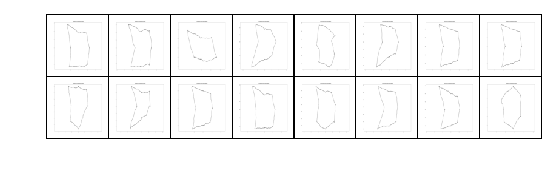

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 100),
            nn.ReLU(inplace=True),

            nn.Linear(100, 5))

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

## Contrastive Loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [41]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=12,
                        batch_size=Config.train_batch_size)

In [42]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr =0.001)

In [ ]:
import matplotlib.pyplot as plt
import torch
import random

# Initialize lists to store accuracy history and iteration number
accuracy_history = []
iteration_number = 0
counter = []
loss_history = []

# Set up the plot for real-time updates
plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots()
accuracy_line, = ax.plot([], [], label="Accuracy")
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Real-Time Accuracy During Training')
ax.set_xlim(0, 1)
ax.set_ylim(0, 100)
ax.legend()

# Training loop
for epoch in range(0, Config.train_number_epochs):
    correct = 0  # To track correct predictions
    total = 0    # To track total number of samples
    
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()

        # Forward pass
        output1, output2 = net(img0, img1)
        
        # Compute contrastive loss
        loss_contrastive = criterion(output1, output2, label)
        
        # Backpropagation and optimization
        loss_contrastive.backward()
        optimizer.step()

        # Calculate accuracy
        with torch.no_grad():
            # Compute Euclidean distance between the output pairs
            euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
            
            # Define a threshold to classify pairs as similar or dissimilar
            threshold = 0.5  # Adjust based on your data
            
            # Predictions: similar if distance < threshold, dissimilar otherwise
            predictions = (euclidean_distance < threshold).float()
            
            # Ensure both predictions and labels are properly scaled for comparison
            predictions = predictions.view(-1)
            label = label.view(-1)

            # Update correct predictions and total count
            correct += (predictions == label).sum().item()
            total += label.size(0)

        # Logging the loss every 10 batches
        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss_contrastive.item()}")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch} Accuracy: {accuracy:.2f}%")

    # Update the plot after each epoch
    accuracy_line.set_xdata(range(1, epoch + 2))  # Update x-axis with epoch number
    accuracy_line.set_ydata(accuracy_history)     # Update y-axis with accuracy history
    ax.set_xlim(0, epoch + 2)                     # Adjust x-axis limit as needed
    fig.canvas.draw()
    fig.canvas.flush_events()

# Turn off interactive mode after training
plt.ioff()

# Final plot after training
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import torch

# Initialize lists to store accuracy history
accuracy_history = []
iteration_number = 0
counter = []
loss_history =[]

# Training loop
for epoch in range(0, Config.train_number_epochs):
    correct = 0  # To track correct predictions
    total = 0    # To track total number of samples
    
    for i, data in enumerate(train_dataloader, 0):
        img0, img1, label = data
        img0, img1, label = img0.cuda(), img1.cuda(), label.cuda()

        optimizer.zero_grad()

        # Forward pass
        output1, output2 = net(img0, img1)
        
        # Compute contrastive loss
        loss_contrastive = criterion(output1, output2, label)
        
        # Backpropagation and optimization
        loss_contrastive.backward()
        optimizer.step()

        # Calculate accuracy
        with torch.no_grad():
            # Compute Euclidean distance between the output pairs
            euclidean_distance = torch.nn.functional.pairwise_distance(output1, output2)
            
            # Define a threshold to classify pairs as similar or dissimilar
            threshold = 0.8  # Adjust based on your data
            
            # Predictions: similar if distance < threshold, dissimilar otherwise
            predictions = (euclidean_distance < threshold).float()
            
            # Ensure both predictions and labels are properly scaled for comparison
            predictions = predictions.view(-1)
            label = label.view(-1)

            # Update correct predictions and total count
            correct += (predictions == label).sum().item()
            total += label.size(0)

        # Logging the loss every 10 batches
        if i % 10 == 0:
            print(f"Epoch {epoch}, Batch {i}, Loss: {loss_contrastive.item()}")
            iteration_number += 10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

    # Calculate accuracy, limit it to 100% maximum
    accuracy = min(100 * correct / total, 100.0)
    accuracy_history.append(accuracy)
    print(f"Epoch {epoch} Accuracy: {accuracy:.2f}%")

# Plot the loss and accuracy history
def show_plot(counter, loss_history, accuracy_history):
    plt.figure(figsize=(10, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(counter, loss_history, label="Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Loss During Training")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, Config.train_number_epochs + 1), accuracy_history, label="Accuracy", color='red')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy During Training")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the function to plot the graphs
show_plot(counter, loss_history, accuracy_history)


## Some simple testing

In [67]:
import os
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("on")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':2})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    name = os.path.join("results",str(i)+".png")
    plt.savefig(name, bbox_inches='tight', pad_inches=0)
    plt.show() 

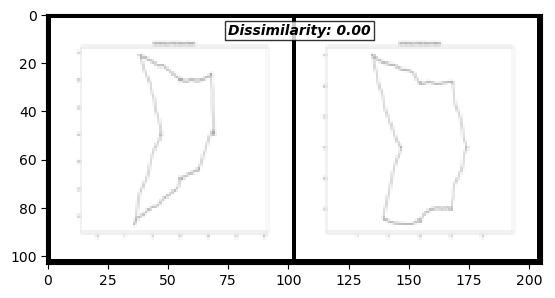

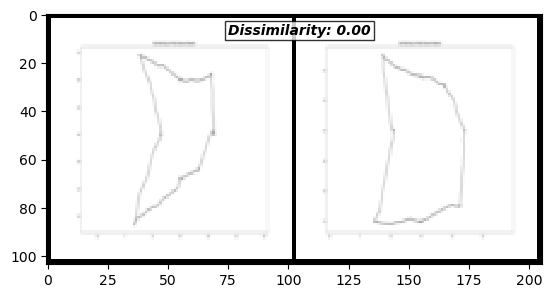

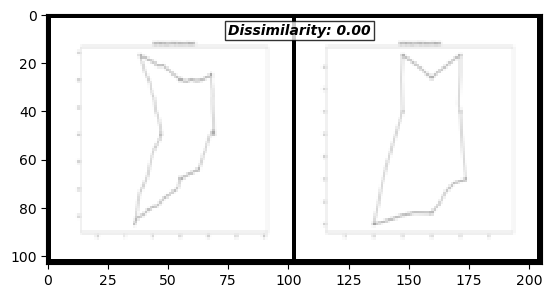

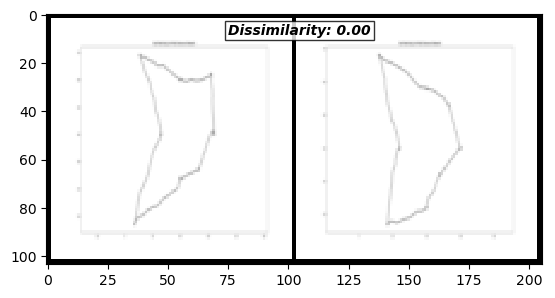

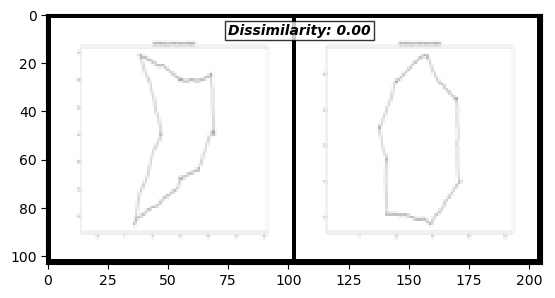

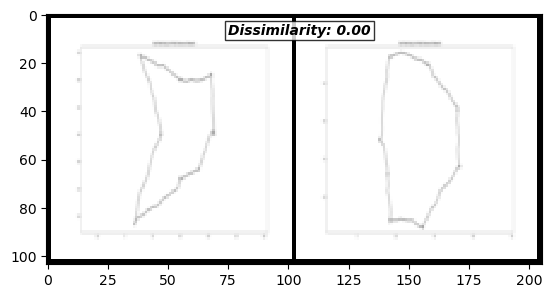

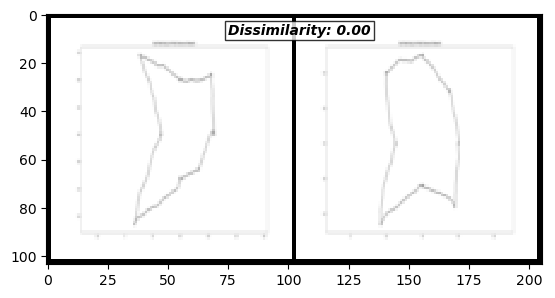

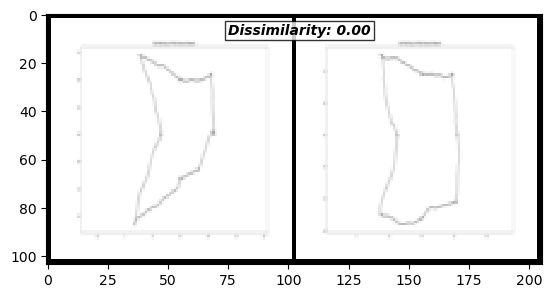

In [68]:
import os
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)

test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=True)
dataiter = iter(test_dataloader)
x0,_,_ = next(dataiter)


for i in range(8):
    _,x1,label2 = next(dataiter)
    concatenated = torch.cat((x0,x1),0)
    
    output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
    euclidean_distance = F.pairwise_distance(output1, output2)
    euclidean_distance = euclidean_distance.item()
    # euclidean_distance = mapping(euclidean_distance)
    imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance), i)
    # np_image = concatenated.numpy().transpose((1, 2, 0))
    # plt.imshow(np_image)
    # plt.axis('off') 
    # name = os.path.join("results",str(i)+".png")
    # plt.savefig(name, bbox_inches='tight', pad_inches=0)
    



In [ ]:
def DH_caculation(D_w, threshold=0.5):
    """
    This function calculates the level of damage based on the provided data (D_w)
    and a given threshold, and categorizes the damage level.

    Parameters:
    - D_w (list): List of D-w from Algorithm 2
    - threshold (float):

    Returns:
    - D_H (float): The percentage of data points that exceed the threshold.
    - damage_level (str): A string indicating the damage category based on D_H.
    """

    E = 0 
    H = len(D_w)  # Total number of data points
    
    # Iterate through the data points
    for i in range(H):
        if D_w[i] > threshold:
            E += 1  # Increment if the value exceeds the threshold
    
    # Calculate the damage level percentage
    D_H = (E / H) * 100 if H > 0 else 0 
    
    # Determine damage level category
    if D_H < 5:
        damage_level = "Healthy level"
    elif 5 <= D_H < 25:
        damage_level = "Minor damage level"
    elif 25 <= D_H < 45:
        damage_level = "General damage level"
    else:
        damage_level = "Serious damage level"
    
    # Output the results
    print("Total time:", H)
    print("Level Damage:", D_H, "%")
    print("Damage Category:", damage_level)
    
    return D_H, damage_level  

DH_caculation(D_w)